## Calculations for the IPEM code of practice for electron dosimetry 2003

First we need to import a number of python libraries

In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import mpUtilities.mc2 as mc2
import mpUtilities.graphUtils as grp
# Note the mpUtilities libraries are custom libraries
import matplotlib.pyplot as plt
import numpy as np

The next two lines import the PDI data files from our plotting tank(in this case for 6MeV and 20 MeV)

In [2]:
ds6 = mc2.read_mc2("./data/electron_PDI/06_MeV.mcc", 161, 232)
ds20 = mc2.read_mc2("./data/electron_PDI/20_MeV.mcc", 268, 384)

To get our depth in cm we divide the depth in each dataset (xdata) by 10. We also normalise the maximum of the dataset to 100%

In [3]:
ds6.ynorm = grp.normalise_to_max(ds6.xdata, ds6.ydata)
ds6.depth = ds6.xdata/10
ds20.ynorm = grp.normalise_to_max(ds20.xdata, ds20.ydata)
ds20.depth = ds20.xdata/10

We can then plot our data for 6 and 20 MeV electron beams

(0, 110)

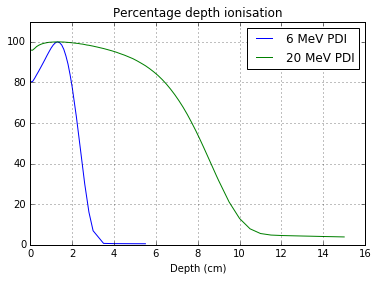

In [4]:
plt.plot(ds6.depth, ds6.ynorm, label='6 MeV PDI')
plt.plot(ds20.depth, ds20.ynorm, label='20 MeV PDI')
plt.grid()
plt.legend()
plt.xlabel("Depth (cm)")
plt.title("Percentage depth ionisation")
plt.ylim(0,110)

This gives us a plot of PDI (Percentage Depth Ionisation).

In order to convert this to a PDD (Percentage Depth Dose) we need to multiply each point in the curve by the water-air stopping power ratio $ S_{w,air}(z) $ at depth $z$.

This can be calculated using the formula:
$$ S_{w,air}(z) = \frac{a + bx +cx^2 +dy}{1 + ex + fx^2 +gx^3 +hy} $$

Values for the constants $a$ - $h$ are given in the Code of Practice

This is written as a Python function below:

In [5]:
def stoppingPowerRatio(R50D,z):
    
    """Given the beam quality R50,D calculates the Spencer Attix stopping power ratios at depth, z, using 
    the fit by Burns et al given in the 2003 IPEM code of practice for electron dosimetry.
    
    This fit is valid for for beam qualities R50,D in the range 1-20 cm of water and for depths of 0.02 to
    1.2 times R50,D"""
    
    a = 1.075
    b = -0.5087
    c = 0.0887
    d = -0.084
    e = -0.4281
    f = 0.0646
    g = 0.00309
    h = -0.125
    x = np.log(R50D)    # np.log gives the natural log ln of a number
    y = z/R50D
    S = (a + b*x + c*x**2 + d*y)/(1 + e*x + f*x**2 + g*x**3 + h*y)
    return S
    

We also need to obtain a value for $R_{50,I}$

In [6]:
def find_R50I(depth, pdd):
    """ This function finds the value of R50I given the depth and PDI datasets"""
    # First we need to use only the descending part of the graph
    depth_down = depth[np.argmax(pdd):]
    pdd_down = pdd[np.argmax(pdd):]
    # `idx` is an an array of integer indices that sorts `pdd` in ascending order
    # see https://stackoverflow.com/questions/34857873/interpolating-a-data-point-on-a-curve-with-a-negative-slope
    idx = np.argsort(pdd_down)
    R50I = np.interp([50.0], pdd_down[idx], depth_down[idx])
    # R50I=np.interp(50, ydown, xdown)
    return R50I

In [7]:
ds6.r50i=find_R50I(ds6.depth,ds6.ynorm)
ds20.r50i=find_R50I(ds20.depth,ds20.ynorm)

$R_{50,D}$ can then be obtained from $R_{50,I}$ by using the formula:

$$ R_{50,D} = 1.029 R_{50,I} - 0.063 cm $$

In [8]:
ds6.r50d = 1.029 * ds6.r50i - 0.063
ds20.r50d = 1.029 * ds20.r50i - 0.063

We can then calculate the stopping power ratios at each depth using the function defined previously

In [9]:
SPR6= stoppingPowerRatio(ds6.r50d,ds6.depth)
SPR20= stoppingPowerRatio(ds20.r50d,ds20.depth)

(0.6, 2)

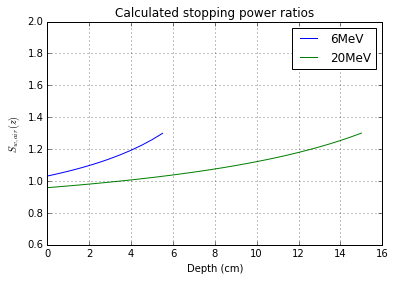

In [10]:
plt.plot(ds6.depth, SPR6, label='6MeV')
plt.plot(ds20.depth, SPR20, label='20MeV')
plt.grid()
plt.legend()
plt.ylabel("$ S_{w,air}(z) $")
plt.xlabel("Depth (cm)")
plt.title("Calculated stopping power ratios")
plt.ylim(0.6,2)

We can then multiply each point in our pdi graph by the appropriate stopping power ratio. We then normalise the maximum of this PDD curve to 100%

In [11]:
ds6.pdd = ds6.ydata*SPR6
ds6.pdd_norm = grp.normalise_to_max(ds6.xdata,ds6.pdd)

ds20.pdd = ds20.ydata*SPR20
ds20.pdd_norm = grp.normalise_to_max(ds20.xdata,ds20.pdd)

(0, 110)

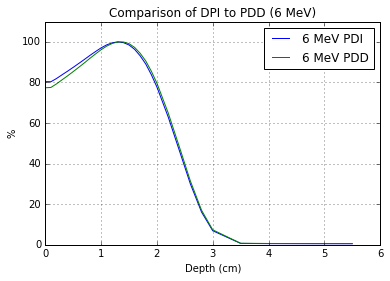

In [12]:
plt.plot(ds6.depth, ds6.ynorm, label='6 MeV PDI')
plt.plot(ds6.depth, ds6.pdd_norm, label= '6 MeV PDD')
plt.grid()
plt.legend()
plt.xlabel("Depth (cm)")
plt.ylabel("%")
plt.title("Comparison of DPI to PDD (6 MeV)")
plt.ylim(0,110)

(0, 110)

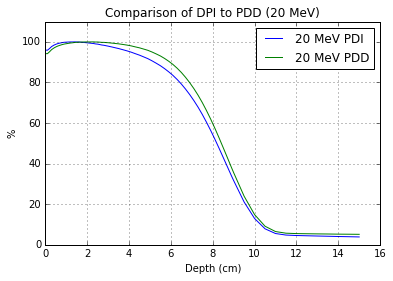

In [13]:
plt.plot(ds20.depth, ds20.ynorm, label='20 MeV PDI')
plt.plot(ds20.depth, ds20.pdd_norm, label= '20 MeV PDD')
plt.grid()
plt.legend()
plt.xlabel("Depth (cm)")
plt.ylabel("%")
plt.title("Comparison of DPI to PDD (20 MeV)")
plt.ylim(0,110)